# **"4.6.2 - Rotífero ou tardígrado?": CNN** 🐛🐻🧠
**Objetivo**: Implementar uma rede neural convolucional (CNN) utilizando PyTorch ou lightning. Treine esta rede neural em um conjunto de dados de imagens. Explique para o leitor como funciona a camada de convolução de uma CNN  e o motivo de utilizarmos este tipo de arquitetura quando estudamos imagens.

**Dupla**: Júlia Guedes A. dos Santos & Lorena Ribeiro Nascimento
***

### **Introdução** 💡

<p style="text-align:justify";>
O presente notebook busca, a partir do dataset desenvolvido no arquivo "4.6.1 - Rotíferos ou tardígrados?: Trabalhando com as imagens", treinar uma Convolutional Neural Network (CNN, do português, Rede Neural Convolucional) para a identificação de tardígrados e rotíferos em imagens de microscopia óptica.
</p>

<p style="text-align:justify";>
Nesse sentido, em primeiro lugar, precisamos definir o conceito de uma CNN. Esse tipo de arquitetura, proposta pela primeira vez em 1998 para trabalhar com o dataset MNIST (composto por imagens de dígitos manuscritos), é comumente utilizado para trabalhar com classificação de imagens e reconhecimento de objetos.  
</p>

<p style="text-align:justify";>
Como entrada, essas redes, em casos de imagens coloridas, recebem matrizes tridimensionais, nas quais cada célula contém o valor do pixel correspondente nos três canais de cor (vermelho, azul e verde). Em imagens preto e branco, por outro lado, as matrizes formadas são bidimensionais (com altura Y e altura Z, respectivas as imagens).
</p>


<p style="text-align:justify";>
Após isso, as principais características dessas imagens são obtidas por meio de métodos convolucionais, sendo que os pesos aprendidos pela rede correspondem, justamente, aos valores dos filtros de convolução utilizados para identificar certas características (<em>feature map </em>). Depois, as imagens passam por uma camada de <em>pooling</em>, a qual busca condensar uma entrada larga ao extrair apenas os recursos mais significativos (geralmente o maior valor ou a média de valores de uma determinada janela).
</p>

<p style="text-align:justify";>
Finalmente, como última etapa, os dados são "achatados" para apenas uma dimensão (<em>flattened</em>) e passam por uma camada totalmente conectada, a qual realiza a classificação da entrada e devolve a saída como uma avaliação probabilística dos rótulos possíveis.
</p>


Para a composição da rede, o módulo Pytorch será utilizado.

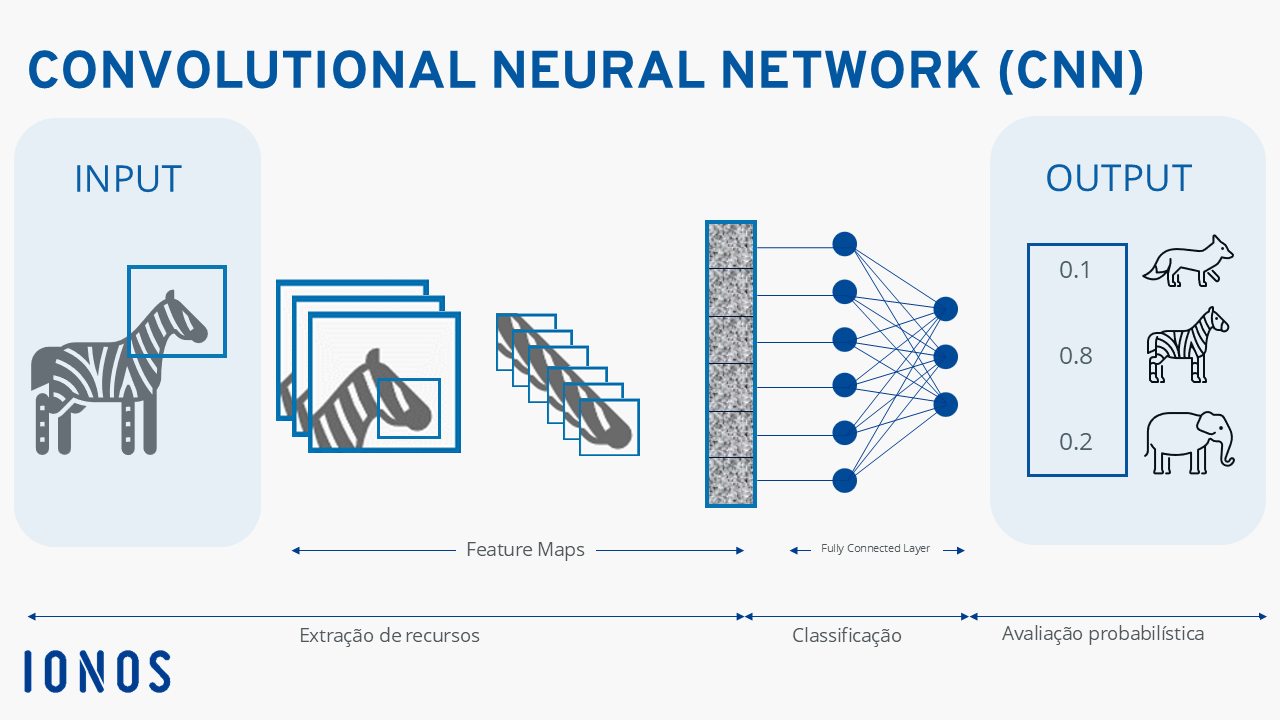

[Figura 1: Funcionamento de uma Rede Neural Convolucional (CNN)] [4]

### **Importação das bibliotecas & Dataset** 📚

Primeiramente, precisamos importar as bibliotecas necessárias para a resolução do problema.

In [50]:
# Módulos do matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Bibliotecas para definição de diretório
import zipfile
import os

# Módulos do Pytorch
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Plot da matriz de confusão
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

A partir disso, é possível importar o dataset resultante do notebook "4.6.1 - Rotíferos ou tardígrados?: Trabalhando com as imagens".

In [2]:
zip_path = "C:\\Users\\julia24002\\OneDrive - ILUM ESCOLA DE CIÊNCIA\\2025 - Primeiro semestre\\Redes Neurais e Algoritmos Genéticos\\Feras formidáveis\\rotiferos_tardigrados_aumentado.zip"
extract_path = "rotiferos_tardigrados"     

with zipfile.ZipFile(zip_path, 'r') as zip_ref:     # extraindo o arquivo em zip
    zip_ref.extractall(extract_path)              

Considerando que iremos trabalhar com a biblioteca Pytorch, antes de iniciar o treinamento, podemos redimensionar o tamanho das imagens para 64x64, utilizando o módulo transforms.

In [3]:
transform = transforms.Compose([                # tranformando para 64x64 e para tensor
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])    

caminho_base= "C:\\Users\\julia24002\\OneDrive - ILUM ESCOLA DE CIÊNCIA\\2025 - Primeiro semestre\\Redes Neurais e Algoritmos Genéticos\\Feras formidáveis\\rotiferos_tardigrados\\Rotiferos-tardigrados"

dataset_treino = ImageFolder(root=f"{caminho_base}\\Treino", transform=transform)
dataset_validacao   = ImageFolder(root=f"{caminho_base}\\Validação", transform=transform)
dataset_teste  = ImageFolder(root=f"{caminho_base}\\Teste", transform=transform)

treino_loader = DataLoader(dataset_treino, shuffle=True)
validacao_loader   = DataLoader(dataset_validacao, shuffle=False)
teste_loader  = DataLoader(dataset_teste, shuffle=False)


Além de redimensionar as imagens, essas foram transformadas para tensores, e os dados foram dividos entre aqueles que serão utilizados para treinamento, validação e teste.

### **Treinamento da rede** 🧠

A partir da CNN implementada na referência 4, é possível implementar uma CNN para treinar os dados importados.

* **Arquitetura escolhida**

A arquitetura utilizada nesse Notebook, e baseada  na referência 4, é composta por duas convoluções, que passam por um processo de pooling (redução  ou simplificação das informações da camada anterior). Por fim, é utilizando apenas uma camada totalmente conectada (em inglês, fully conectec(Fc)) e a função de ativação Relu, que consiste em zerar os valores de saída negativos e é a mais indicado para CNN por ser mais eficiente computacionalmente e com desempenho similar (ou até superior) às demais funções.

Vale ressaltar que antes, de entrar na camada totalmente conectada, os dados precisam passar por um processo de "flatten", que consiste em transformar os dados para uma dimensão.

* **Como realizar os cálculos dos parâmetros da rede?**

Para essa arquitetura, foi utilizado alguns parâmetros, dentre eles, um pooling com redução dos dois lados da imagem pela metade. Quanto as camadas convlucionais apresentam três parâmetros, sendo o primerio a quantidade de canais, sendo 3 na primeira, visto que é uma imagem em RGB, e 4 na segunda por conta da saída gerada pela primeira convolução. O segundo parâmetro consiste na quantidade de filtros aplicados nas convoluções, sendo 4 na primeira e 9 na segunda. Quanto ao último parâmetro, esse corresponde ao tamanho do filtro, sendo um filtro 3x3 na primeira e 4x4 na segunda.

Em relação aos parâmetros da camada totalmente conectada, é preciso calcular o número de features de saída, para isso utilizamos a equação mostrada a baixo. A partir disso, é calculado o primeiro argumento, sendo esse a multiplicação do número de canais pela dimensionalidade (metade do valor do número de saída, sendo esse os valores das alturas). Sendo o último argumento dessa camada é a quantidade de neurônios, portanto dois.


$$
n_{out} = [\frac{n_{in} + 2p - k}{s}] + 1
$$

<p style="text-align:center;">
[Fórmula 1: Cálculo da quantidade de features de saída]
</p>

* $n_{in}$: Número de features de entrada
* $n_{out}$: Número de features de saída
* $k$: tamanho do kernel de convolução
* $p$: tamanho do padding de convolução
* $s$: tamanho do stride de convolução


In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 4, 3)        # como saída, teremos 4 canais de 62x62 (64-3+1=62)
        self.pool = nn.MaxPool2d(2, 2)         # como saída, teremos 4 canais de 31x31 (62/2=31)       

        self.conv2 = nn.Conv2d(4, 9, 4)        # como saída, teremos 9 canais de 14x14 (31-4+1=28)

        self.fc1 = nn.Linear(9 * 14 * 14, 2)  # Flatten (9,14,14)

    def forward(self, x):
        # forward pass da CNN, utilizando ReLU como função de ativação 

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # transformando para uma dimensão, para entrar nas camadas totalmente conectadas
        x = self.fc1(x) # saída da rede, que seria um tensor com dois valores (um para cada classe), indicando a energia da rede para cada classe
        return x


In [6]:
cnn = CNN()

Após instanciar a rede, precisamos delimitar qual será o otimizador utilizado (Descida do gradiente estocástico) e a taxa de aprendizado (0.001). 

In [7]:
otimizador = optim.SGD(cnn.parameters(), lr=0.001) # definiçção do otimizador (SGD) e da taxa de aprendizado (0.001)
criterio = nn.CrossEntropyLoss() # função de perda (Cross Entropy Loss)

Por fim, a rede será treinada durante 100 épocas, sendo calculado a perda dos dados de treino e teste, e implementando o otimizador e o critério da perda.

In [8]:
loss_treino_lista = []
loss_validacao_lista = []

for epoca in range(100):
    
    cnn.train() # Modo de treinamento
    
    loss_treino_total = 0.0
    
    for i, data in enumerate(treino_loader, 0):
        

        inputs, labels = data
        
        otimizador.zero_grad()

        outputs = cnn(inputs)
        loss_treino = criterio(outputs, labels)
        loss_treino.backward()
        otimizador.step()
        
        loss_treino_total += loss_treino.item()

    media_loss_treino = round(loss_treino_total / len(treino_loader), 4)
    
    loss_treino_lista.append(media_loss_treino)
        
    
    cnn.eval()  # Modo de validação
    loss_validacao_total = 0.0
    
    with torch.no_grad():  # Desativação do cálculo do gradiente
        for i, data in enumerate(validacao_loader, 0):

            inputs, labels = data
            
            outputs = cnn(inputs)
            loss_validacao = criterio(outputs, labels)
            
            loss_validacao_total += loss_validacao.item()
            
        media_loss_validacao = round(loss_validacao_total / len(validacao_loader), 4) 
         
        loss_validacao_lista.append(media_loss_validacao)
        
    print(f"O erro da época {epoca} é igual a {loss_treino.item()}")

O erro da época 0 é igual a 0.5637577176094055
O erro da época 1 é igual a 0.9425564408302307
O erro da época 2 é igual a 1.0148801803588867
O erro da época 3 é igual a 0.8081800937652588
O erro da época 4 é igual a 0.5295590162277222
O erro da época 5 é igual a 0.506599485874176
O erro da época 6 é igual a 0.9709339141845703
O erro da época 7 é igual a 0.9348008632659912
O erro da época 8 é igual a 0.514345109462738
O erro da época 9 é igual a 0.5330429077148438
O erro da época 10 é igual a 0.5099021196365356
O erro da época 11 é igual a 0.532811164855957
O erro da época 12 é igual a 0.9368733167648315
O erro da época 13 é igual a 0.8822304010391235
O erro da época 14 é igual a 0.8826888203620911
O erro da época 15 é igual a 1.0221549272537231
O erro da época 16 é igual a 0.5286508798599243
O erro da época 17 é igual a 0.958107590675354
O erro da época 18 é igual a 0.9057207107543945
O erro da época 19 é igual a 0.9638196229934692
O erro da época 20 é igual a 0.837509274482727
O erro 

### **Análise de resultados** 📊

Para a análise dos resultados obtidos foi calculada a acurácia e a matriz de confusão desse modelo.

##### **Acurácia**

In [23]:
tamanho_teste = len(teste_loader.dataset)
previsoes_corretas =  0 
y_real = []
y_pred = []
with torch.no_grad():
    for data in teste_loader:
        entradas, rotulos = data
        y_real.append(rotulos)
        
        saidas = cnn(entradas)
        #print(saidas)
        _, previsoes = torch.max(saidas,1)
        y_pred.append(previsoes)
        
        previsoes_corretas += (previsoes == rotulos).sum().item()
    print(f"A acurácia da CNN é igual a {previsoes_corretas/tamanho_teste}")
        

A acurácia da CNN é igual a 0.65


A acurácia dessa CNN foi de 65%, que corresponde a um valor maior do que o baseline, sendo assim, é um valor razoável, principalmente levando em consideração que é uma rede pequena, com poucos dados, que torna mais difícil uma predição com alta acurácia, principalmente sendo organismos com aspectos semelhantes e com muitas variações nas imagens.

##### **Matriz de confusão**

In [46]:
y_real_lista = ["Rotiferos" if i.item() == 1 else "Tardigrados" for i in y_real]

In [47]:
y_pred_lista = ["Rotiferos" if i.item() == 1 else "Tardigrados" for i in y_pred]

In [48]:
dataset_teste.classes

['Rotiferos', 'Tardigrados']

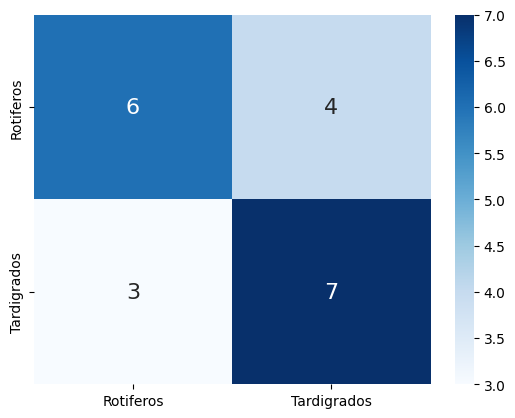

In [52]:
matriz_conf = confusion_matrix(y_real_lista, y_pred_lista, labels=dataset_teste.classes)
df_conf = pd.DataFrame(matriz_conf, dataset_teste.classes, dataset_teste.classes)
sns.heatmap(df_conf, annot=True, annot_kws={"size": 16}, cmap='Blues');

A matriz de confusão representa a relação das predições, ou seja, a relação entre o que os dados continham de informação, com o que foi previsto. Nesse caso, observa-se que, dentre as 20 predições, em 13 deles o resultado foi correto, em que se preveu tardigrados e rotíferos corretamente. A predições dos tardigrados foi um pouco maior, mas como foi um pequena diferença, não é razoavel afirmar que o modelo aprendeu a identificar mais esse organismo.

### **Conclusão** 😶‍🌫️

Conclui-se que foi possível desenvolver um modelo de CNN para a predição de tadígrados e rotíferos a partir de imagens de microscopia óptica, sendo comprovado pela análise dos dados, com uma acurácia de 65% e uma matriz de confusão com maioria dos dados dentro das predições esperadas. Vale ressaltar que esse treinamento foi feito com um dataset próprio e com poucas imagens, sendo assim, uma dataset maior poderia levar a um modelo ainda mais acurado. Portanto, esse Notebook mostrou como foi feito o treinamenteo para uma CNN com objetivo de identificação de organismo microscópicos e foco de diversos estudos, e os resultados relevantes dele.

### **Referências** 🗃️

[1] O que são redes neurais convolucionais? | IBM. Disponível em: <https://www.ibm.com/br-pt/think/topics/convolutional-neural-networks>. Acesso em: 18 abr. 2025.

[2] POLONI, Katia. Redes neurais convolucionais. Disponível em: <https://medium.com/itau-data/redes-neurais-convolucionais-2206a089c715>. Acesso em: 18 abr. 2025.

[3] Convolutional Neural Network: Redes neurais convolucionais. IONOS Digital Guide. Disponível em: <https://www.ionos.com/pt-br/digitalguide/sites-de-internet/desenvolvimento-web/convolutional-neural-network/>. Acesso em: 18 abr. 2025.

[4] Training a Classifier — PyTorch Tutorials 2.6.0+cu124 documentation. Disponível em: <https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html>. Acesso em: 18 abr. 2025.

[5] HIEN, Dang Ha The. A guide to receptive field arithmetic for Convolutional Neural Networks. Medium. Disponível em: <https://blog.mlreview.com/a-guide-to-receptive-field-arithmetic-for-convolutional-neural-networks-e0f514068807>. Acesso em: 18 abr. 2025.
